In [ ]:
from itertools import islice, cycle
from tau_profile_parser import TauProfileParser
import pandas as pd
import plotly.graph_objs as go

Plotly Bar Plot Examples
========================

This notebook demonstrates using the TauProfileParser to parse TAU profile.x.y.z files and using Plotly to generate ParaProf-style bar plots from them.

The TAU Profile Parser
----------------------

First, we call `TauProfileParser.parse` on the path to a directory containing TAU profile files. 

Note that the parser does not currently have any native support for MULTI_ directories, so if you have those
you'll have to call parse multiple times and then, if you wish, merge the resulting dataframes. This functionality should be added to the parser.

In [ ]:
lulesh_data = TauProfileParser.parse('lulesh_profile')

This returns an object that provides access to the metric name, metadata, and the interval and atomic/userevent data.

The `metric` attribute contains the metric that values in this profile represent. (This representation will need to change when multi-metric data can be read in directly)


In [ ]:
lulesh_data.metric

The `metadata` attribute contains a Python dictionary of the metadata recorded in the profile.0.0.0 file

In [ ]:
lulesh_data.metadata

The `indices` attribute contains the (node, context, thread) tuples that are present in this profile.

In [ ]:
lulesh_data.indices

The `atomic_data()` function returns a Pandas dataframe containing the atomic events (user and context events). This is a multi-index dataframe with Node, Context, Thread, and Timer as the indices.

(This profile was collected with an instrumented version of Open MPI which collects memory allocations for different object sizes.)

In [ ]:
lulesh_data.atomic_data()

The `interval_data()` function returns the timer data. As with atomic_data(), it is returned as a multi-index Pandas dataframe with Node, Context, Thread, and Timer as the indices.

In [ ]:
lulesh_data.interval_data()

We can manipulate this using normal Pandas functions. For example, here are the timers on (0,0,0) sorted by number of calls descending.

In [ ]:
lulesh_data.interval_data().loc[0,0,0].sort_values('Calls', ascending=False)

Find the mean exclusive time for each timer across all (node, context, thread) indices.

In [ ]:
lulesh_data.interval_data().groupby('Timer').agg({'Exclusive': 'mean'}).sort_values('Exclusive', ascending=False)

Plotly Stacked Bar Chart: The ParaProf Overall Profile View
-----------------------------------------------------------

Plotly can be used to generate bar plots similar to those that ParaProf generates.

This section demonstrates producing a plot similar to ParaProf's overview, the mode that profiles are first opened in. We want to generate something like this, which what ParaProf generates for the profile that we've loaded as `lulesh_data`:

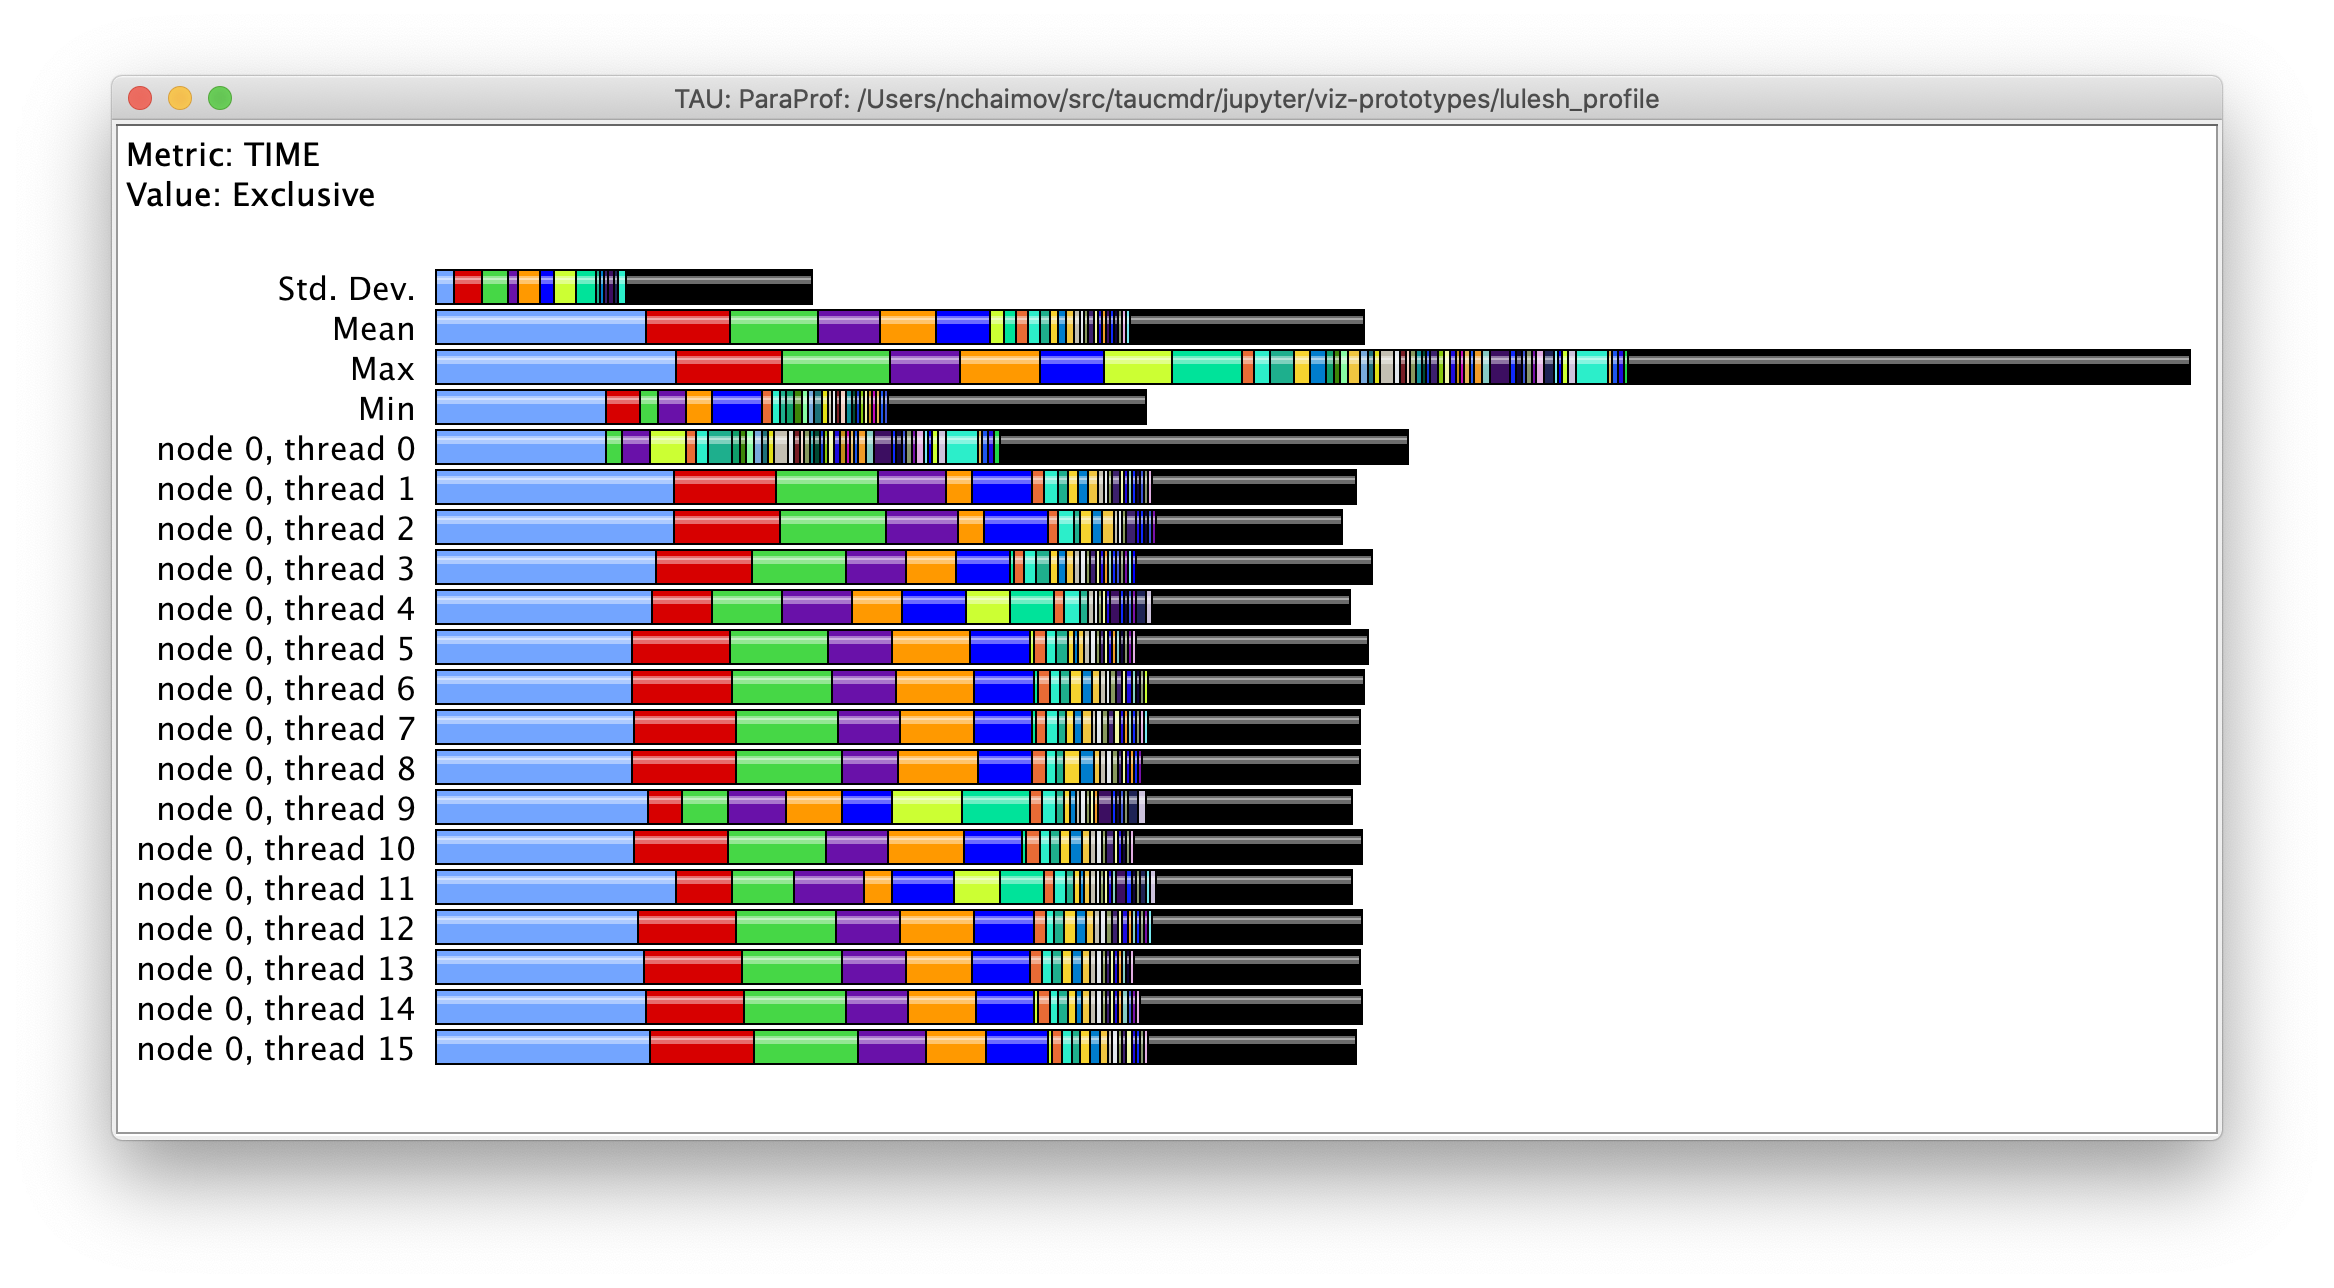 

First, we get a DataFrame containing the Exclusive timing values.

In [ ]:
COL_NAME = 'Exclusive'
metric_data = lulesh_data.interval_data()[[COL_NAME]]
metric_data

Next, we change the shape of the dataframe to match what Plotly expects. We want the data to be sorted in the order we stacked bars to appear in the plot, and we want there to be some value for every timer on every `(n,c,t)`. 

We start by `unstack`ing the DataFrame, which "pivots" the dataframe, promoting the innermost index to a column. This results in each timer name being a distinct column rather than part of each row. This ensures that there is an entry for every timer on every `(n,c,t)`. Where a timer is missing, it now exists and has the value `NaN`.

We then sort the columns descending by the timer values on (0,0,0). When we construct the plot, this order will be used for every `(n,c,t)`.

Finally, we transpose the DataFrame to restore the timers as rows, and fill in `NaN` values with 0.

In [ ]:
sorted_data = metric_data.unstack().sort_values((0, 0, 0), axis=1, ascending=False).transpose().fillna(0)
sorted_data

The profile overview in ParaProf does not include *all* the timers, but only the top N timers instead, with other time being attributed to an "other" timer colored black on the plot.

Thus, next we want to truncate the DataFrame, including only the top N timers. 

(Note that this truncates based on the top N timers on `(0,0,0)` and applies this to all the threads)

This is done by concatenating the dataframe obtained from slicing the dataframe to obtain the first `TOP_N` rows with the dataframe obtained by summing the slice of all the remaining rows; that row is named "Other" 

In [ ]:
TOP_N = 10
truncated = pd.concat([sorted_data[:TOP_N], sorted_data[TOP_N:].sum(level=0).rename({COL_NAME: 'Other'})], copy=False)
truncated

As our final preparation before generating the plot, we get the `(n,c,t)` indices to use as labels in the plot.

In [ ]:
indices = ["node {}, thread {}".format(n, t) for (n,c,t) in truncated.columns.values]
num_indices = len(indices)

The GraphObject interface to Plotly takes lists of graph objects that are to be plotted. Here, we generate a Plotly Bar object for each row in the final version of the DataFrame (so, one Bar object for each Timer).

An example of creating a stacked horizontal bar chart is available in the Plotly documentation at https://plotly.com/python/horizontal-bar-charts/#colored-horizontal-bar-chart

In the list of Bar objects, each entry represents all the timer values for a specific timer on all `(n,c,t)` combinations.

In [ ]:
data = [go.Bar(
    y=indices[::-1],      # These are the labels on the Y axis. These are reversed so that (0,0,0) ends up on the top
    x=row.values[::-1],   # The timer values also have to be reversed so that they appear with the correct index
    orientation='h',      # Make this a horizontal bar plot (default is vertical)
    hoverinfo='text',     # When hovering over a region, show custom text. 
    # The custom text is the first 75 characters of the timer name.
    text=["<br>".join([index[1][i:i + 75] for i in range(0, len(index[1]), 75)])] * num_indices
) for index, row in truncated.iterrows()]

data[-1]['marker'] = {'color': '#000000'} # Make the last entry (the "Other" entry) have a black color
data[-1]['text'] = 'Other'                # Name the last entry "Other"

layout = go.Layout(
    barmode='stack',     # Specify a stacked bar plot
    showlegend=False,    # Hide the legend
    hovermode='closest', # Only show the pop-up label for the region that the mouse cursor is currently over
    title='{} {}'.format(COL_NAME, lulesh_data.metric.decode()) # A title for the graph
)

fig = go.Figure(data=data, layout=layout)
fig

This can be encapsulated into a function to produce such charts:

In [ ]:
def profile_overview_plot(trial_data, col_name, top_n):
    metric_data = trial_data.interval_data()[[COL_NAME]]
    sorted_data = metric_data.unstack().sort_values((0, 0, 0), axis=1, ascending=False).transpose().fillna(0)
    truncated = pd.concat([sorted_data[:top_n], sorted_data[top_n:].sum(level=0).rename({col_name: 'Other'})], copy=False)
    indices = [str(i) for i in truncated.columns.values]
    num_indices = len(indices)
    data = [go.Bar(
        y=indices[::-1],      # These are the labels on the Y axis. These are reversed so that (0,0,0) ends up on the top
        x=row.values[::-1],   # The timer values also have to be reversed so that they appear with the correct index
        orientation='h',      # Make this a horizontal bar plot (default is vertical)
        hoverinfo='text',     # When hovering over a region, show custom text. 
        # The custom text is the first 75 characters of the timer name.
        text=["<br>".join([index[1][i:i + 75] for i in range(0, len(index[1]), 75)])] * num_indices
    ) for index, row in truncated.iterrows()]

    data[-1]['marker'] = {'color': '#000000'} # Make the last entry (the "Other" entry) have a black color
    data[-1]['text'] = 'Other'                # Name the last entry "Other"

    layout = go.Layout(
        barmode='stack',     # Specify a stacked bar plot
        showlegend=False,    # Hide the legend
        hovermode='closest', # Only show the pop-up label for the region that the mouse cursor is currently over
        title='{} {}'.format(col_name, trial_data.metric.decode()) # A title for the graph
    )
    
    fig = go.Figure(data=data, layout=layout)
    return fig

Here is the plot of the top 30 timers:

In [ ]:
profile_overview_plot(lulesh_data, col_name='Exclusive', top_n=30)

This is similar to the Overall Profile view in ParaProf. It lacks the Std. Dev., Mean, Max, and Min rows, but adding them should not be particularly difficult -- those would simply need to be added as columns to the DataFrame used to generate the plot.

Individual Profile Plot
-----------------------

Another view in ParaProf is the view for an individual profile; for example, this view which shows all the timers from `(0,0,0)` from `lulesh_data`.

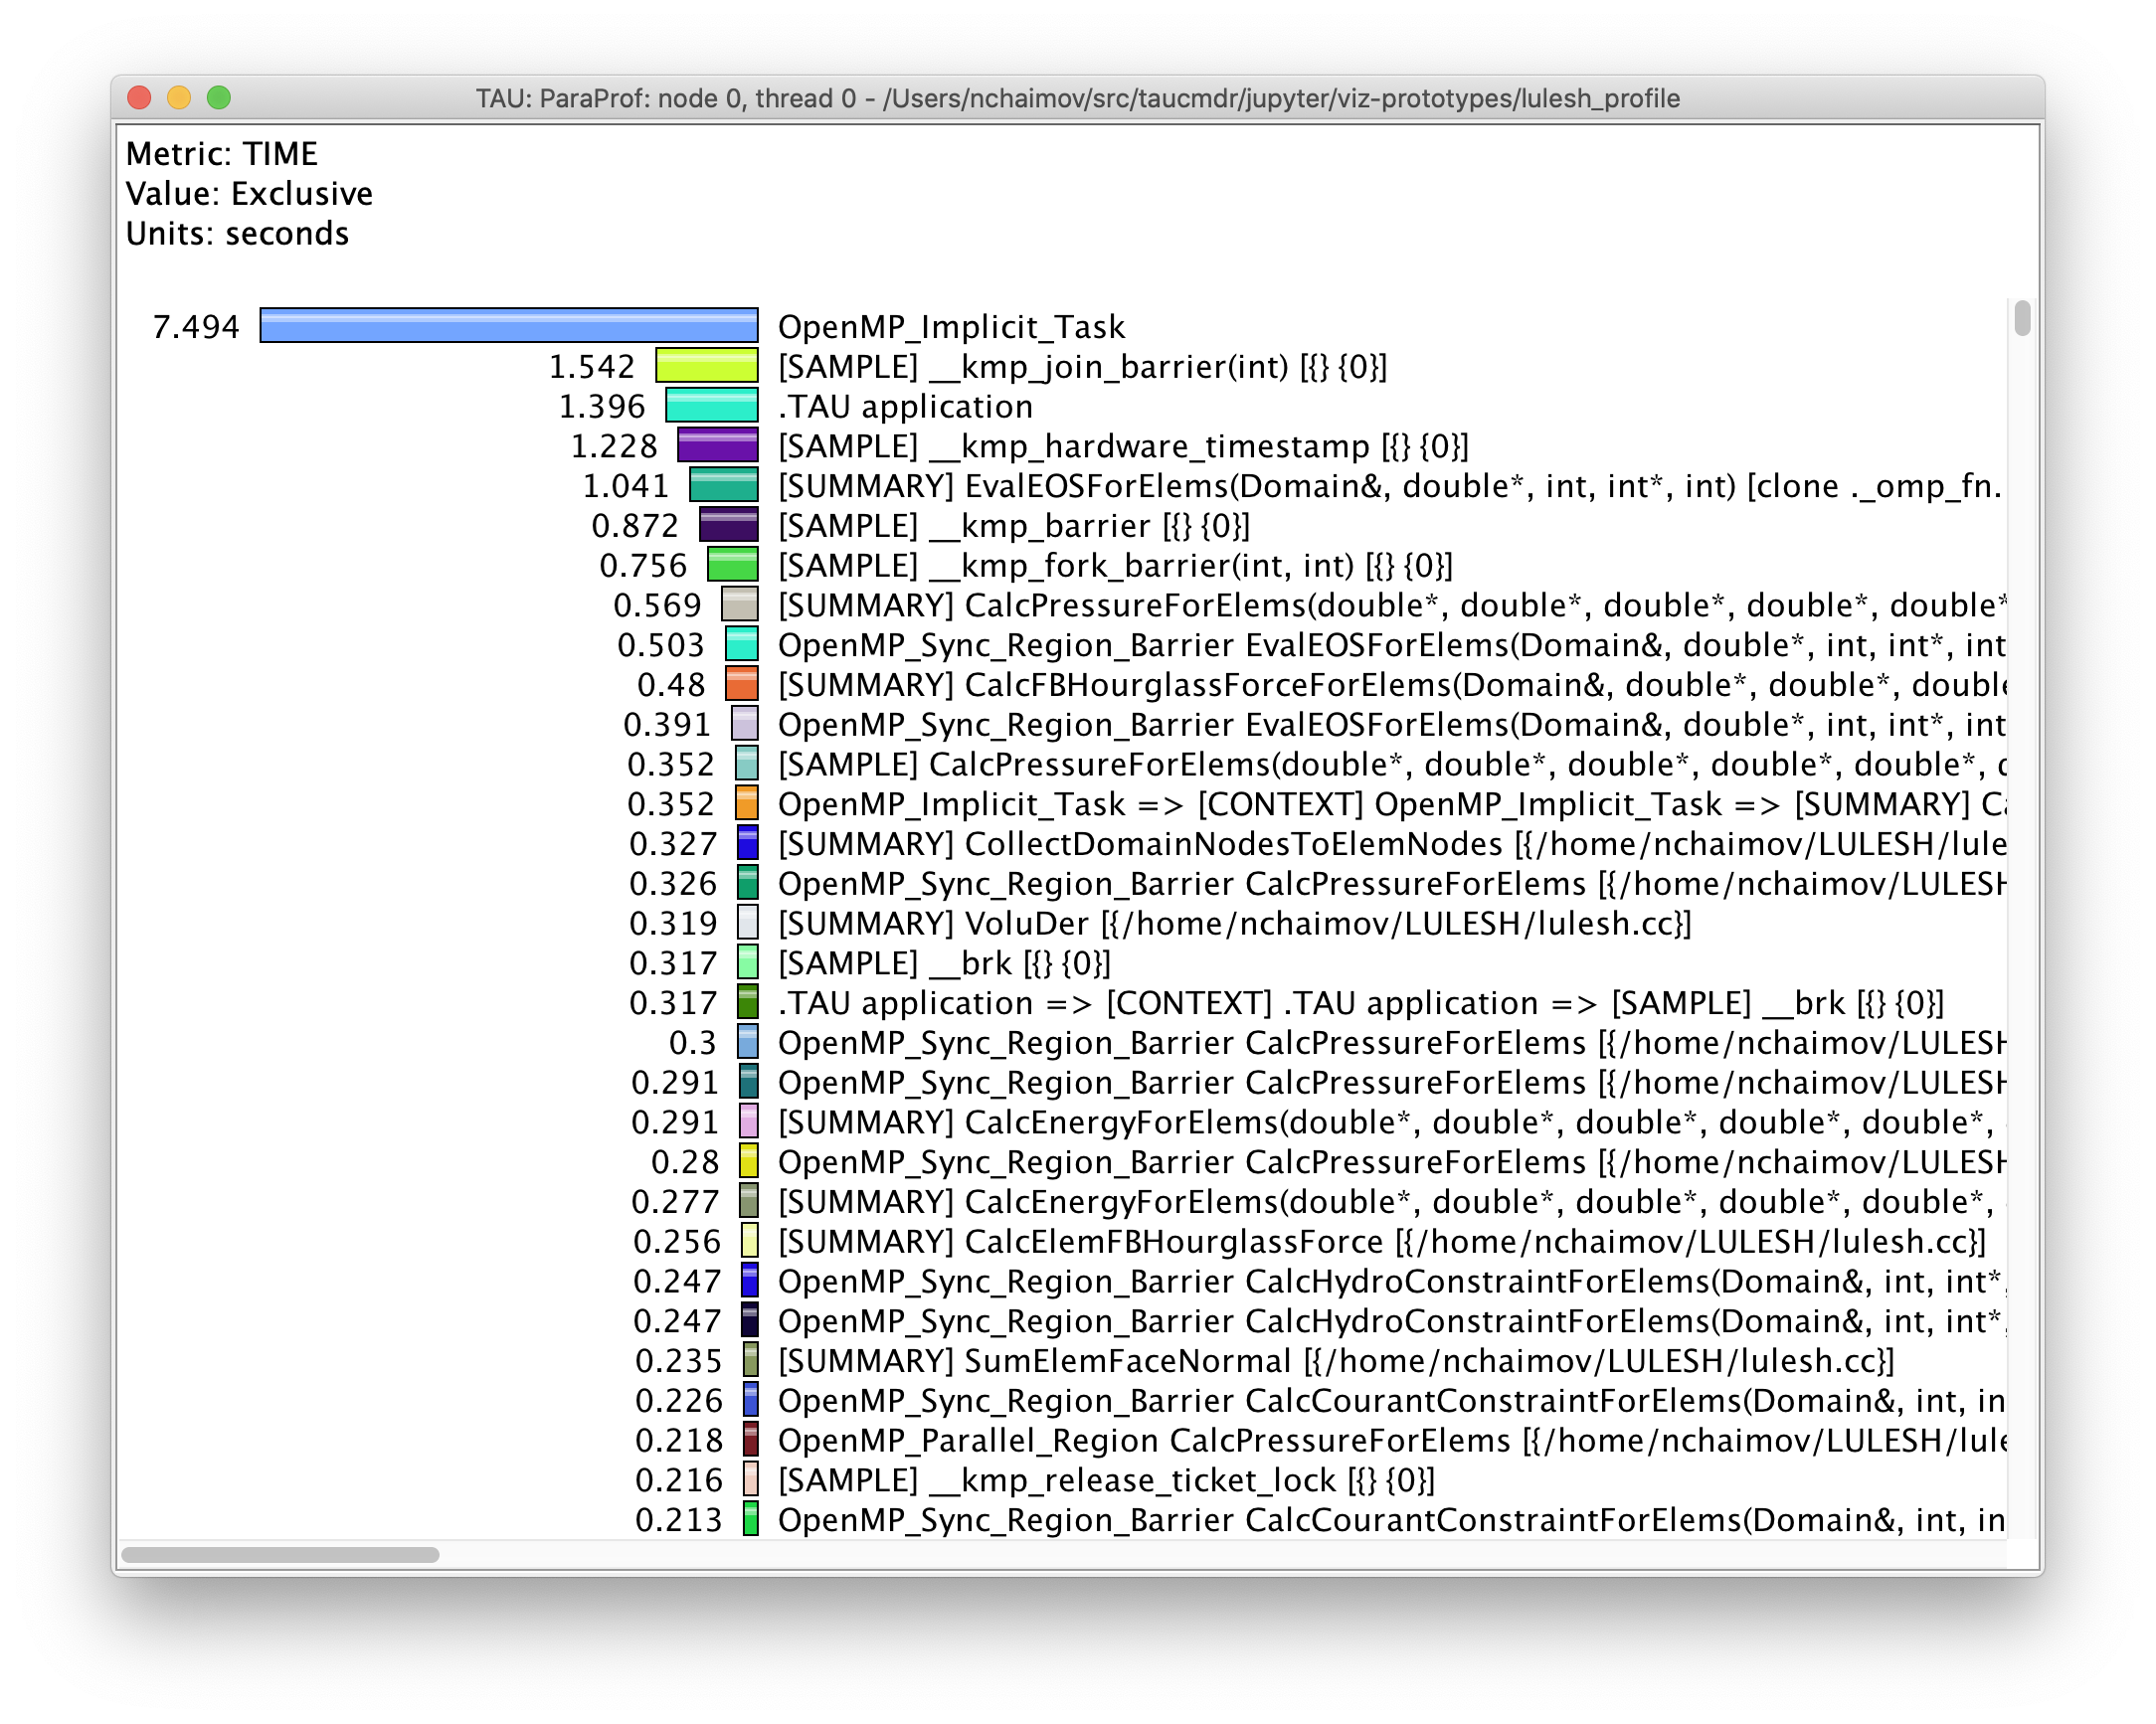 

A complication is that Plotly will give all the plots the same color by default, since they come from the same series. As such, we have to provide colors. In the prototype integrated into TAU Commander, I used a third party library to generate a palette of colors to select from. To avoid having a dependency on Bokeh in this notebook, the colors are simply directly included in the cell below, but see also https://github.com/ParaToolsInc/taucmdr/blob/enterprise/packages/taucmdr/gui/color.py for the version that uses palettes from the Bokeh library.

In [ ]:
colors_str = "#1f77b4,#aec7e8,#ff7f0e,#ffbb78,#2ca02c,#98df8a,#d62728,#ff9896,#9467bd,#c5b0d5,#8c564b,#c49c94,#e377c2,#f7b6d2,#7f7f7f,#c7c7c7,#bcbd22,#dbdb8d,#17becf,#9edae5,#7fc97f,#beaed4,#fdc086,#ffff99,#386cb0,#f0027f,#bf5b17,#666666,#1b9e77,#d95f02,#7570b3,#e7298a,#66a61e,#e6ab02,#a6761d,#666666,#fbb4ae,#b3cde3,#ccebc5,#decbe4,#fed9a6,#ffffcc,#e5d8bd,#fddaec,#f2f2f2,#393b79,#5254a3,#6b6ecf,#9c9ede,#637939,#8ca252,#b5cf6b,#cedb9c,#8c6d31,#bd9e39,#e7ba52,#e7cb94,#843c39,#ad494a,#d6616b,#e7969c,#7b4173,#a55194,#ce6dbd,#de9ed6,#8dd3c7,#ffffb3,#bebada,#fb8072,#80b1d3,#fdb462,#b3de69,#fccde5,#d9d9d9,#bc80bd,#ccebc5,#ffed6f,#3182bd,#6baed6,#9ecae1,#c6dbef,#e6550d,#fd8d3c,#fdae6b,#fdd0a2,#31a354,#74c476,#a1d99b,#c7e9c0,#756bb1,#9e9ac8,#bcbddc,#dadaeb,#636363,#969696,#bdbdbd,#d9d9d9"
colors = colors_str.split(',')

First, we get the interval data and sort it. For this example, we'll use the data from `(0,0,0)`:

In [ ]:
INDEX = (0,0,0)
COL_NAME = 'Exclusive'

sorted_frame = lulesh_data.interval_data().loc[INDEX][[COL_NAME]].sort_values(COL_NAME)
sorted_frame

Next, we get the maximum value, which we will use to set the scale for the axes.

In [ ]:
smax = sorted_frame[COL_NAME].max()
smax

We then plot using Plotly.

In [ ]:
data = [
    go.Bar(
        x=sorted_frame[COL_NAME],     # Timer Values
        y=sorted_frame.index.values,  # Timer Names
        orientation='h',              # Horizontal
        marker=dict(
            # Pick the next color from the list. If we run out of colors, start over.
            color=list(islice(cycle(colors), sorted_frame.shape[0])),    
        ),
        text=sorted_frame.index.values, # Label the entries with the timer time
        textposition='outside',         # and put those labels on the outside of the bar
    )
]

layout = go.Layout(
    autosize=True,
    height=25 * sorted_frame.shape[0],
    margin=go.layout.Margin(
        l=0,
        r=0,
        b=0,
        t=10,
    ),
    xaxis=dict(
        # Expand the X axis range a bit so that the bars don't appear right at the edge, and to leave space for the labels
        range=[-0.1 * smax, smax * 1.25]
    ),
)

fig = go.Figure(data=data, layout=layout)
fig

To match ParaProf, this needs to have the bars grow in the other direction (left-to-right) and display the timer values directly on the plot.

I haven't figured out how to get Plotly to do those things yet.